# リバーシAIを作って魔王を倒そう
このワークでは、リバーシアドベンチャーに存在する魔王を倒すために、オセロAIを構築していきます。  
最初にデータセットの確認していき、AIの構築、学習を行っていきます。    
最後にシミュレーター環境で魔王とAIを戦わせることで、 魔王を倒すAIが作れていることを確認しましょう。

## 必要なライブラリのインポートや準備
まず、今回の学習モデルに必要なライブラリのインポートをしていきましょう

In [1]:
from tensorflow import keras
import japanize_matplotlib
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

2024-01-23 11:23:48.595298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from utils import utils # リバーシ関連の便利な機能があるモジュール
import reversi #　リバーシの操作に関連する機能があるモジュール

## データセットの確認
インポートができたら、今回AIを学習させるために使うデータを確認してみましょう

In [3]:
import pickle
f = open('reversi_dataset/raw_data.txt', 'rb')
data = pickle.load(f)

In [4]:
df = pd.DataFrame(data, columns=["盤面", "手番", "有効手", "白の囲み具合", "黒の囲み具合", "何石差で終局するか"])
df

,盤面,手番,有効手,白の囲み具合,黒の囲み具合,何石差で終局するか
0,...........................10......01............,0,4,10,10,2
1,...........................10......000...........,1,-3,19,5,2
2,...........................10......100.....1.....,0,5,13,15,2
3,..................0........00......100.....1.....,1,-4,24,10,2
4,..................01.......10......100.....1.....,0,6,18,18,2
...,...,...,...,...,...,...
1199041,000000010011111100001110000011000011000.011110...,1,-5,14,3,4
1199042,000000010011111100001110000011000011000.011110...,0,0,11,1,4
1199043,0000000100111111000011110000111100111111011110...,0,2,5,6,4
1199044,0000000100101111000001110000101100111101011110...,1,-2,7,3,4


データセットを見ると、まず盤面の情報が、`空きマスが'.'`、`白石が'0'`、`黒石が'1'`で表現されていることがわかります。  
次に、今石を置くプレイヤーが誰なのかを示す手番の情報があり、また置ける場所の有効手の情報も含まれていそうです。  
その後は、白と黒がそれぞれ相手をどれくらい囲んでいるかの情報と、最終的に終局まで対戦した時に、何石差で終局するかのデータがあります。  
データから、<font color="red">最後以外のデータが、AIを学習するために使えるデータセットで、  
最後のデータはゲームの結果なので、今回のAIが学習する答えとなるラベル</font>になります。  
また、最後の石の数を予測するということで、このAIは、  
<font color="red">ある盤面でAIが試合状況の優劣を予測する</font>(=評価値を作る)ということになります。

# データセットを学習データとテストデータに分割
1日目にやったように、AIを学習するためには、学習データとテストデータが必要です。  
そのため、先ほど確認したデータを、学習データとテストデータに分割します。  
データの変換に時間がかかるので、今回はデータの変換を行ったトレインデータとテストデータを持ってくることとします。  
また、データの前処理を行なっていくつか特徴量を追加しています。

In [5]:
f = open('reversi_dataset/train_data.txt', 'rb')
train_data = pickle.load(f)

In [6]:
f = open('reversi_dataset/train_labels.txt', 'rb')
train_labels = pickle.load(f)

In [7]:
f = open('reversi_dataset/test_data.txt', 'rb')
test_data = pickle.load(f)

In [8]:
f = open('reversi_dataset/test_labels.txt', 'rb')
test_labels = pickle.load(f)

# AIの構築
データの用意ができたので、次にAIを構築していきます。  
今回は既に少しだけ学習させたモデルがあるので、それをロードしてきます。  
また、AIの構成を確認してみましょう。

In [9]:
model = keras.models.load_model('model/model_1126.h5') # 事前に少し学習させたAIをloadします
utils.show_model(model)

2024-01-23 11:23:57.094120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 11:23:57.104761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 11:23:57.107694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

AIが横に長くなっていると思いますが、これは、最初に確認した盤面の情報から、  
前処理でたくさんの別の情報を作って、AIに渡しているからです。  
なので、実際のAIの複雑さでいうとそこまで複雑ではなく、  
1日目にやった`Dense`(ニューラルネットワーク)を基本としたシンプルなモデルだということがわかります。

# AIの学習
構築したAIを使用して、データセットで学習を行います。  
学習することによって、AIは最後の盤面の石の数を予測します。  
これがリバーシAIの、「ある盤面での評価値」として使われることになります。

In [12]:
# csvに学習の進み具合を保存する様にします
csv_logger = keras.callbacks.CSVLogger('training.csv', separator=',', append=True)

In [13]:
# AIの学習
# 大体5分くらいかかります
# todo ここまできたら、一旦みんなの進捗状況を確認して、スライドに移れる様にする
model.fit(
    x=train_data, # 学習のデータを入れます
    y=train_labels, # 学習の答えのデータを入れます
    epochs=1, # 学習の回数を入れます。今回は1で良いです 
    validation_data=(test_data, test_labels),  # テスト用のデータと答えを入れます
    callbacks=[csv_logger] # 学習の進み具合を保存する様にします
)

2024-01-23 11:24:09.756212: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56378fb5ef30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-23 11:24:09.756256: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-01-23 11:24:09.763483: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-23 11:24:09.946392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2024-01-23 11:24:10.065864: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33724/33724 [==============================] - 285s 8ms/step - loss: 0.0162 - mae: 0.0907 - val_loss: 0.0161 - val_mae: 0.0904


### 学習過程の可視化

学習が終わったら、学習の進捗をグラフで確認します。

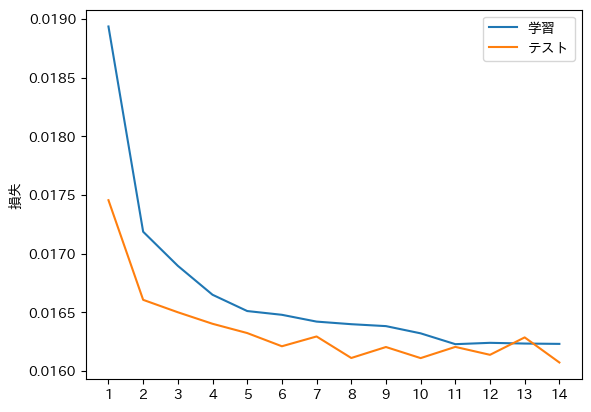

In [14]:
%matplotlib inline

df = pd.read_csv('training.csv') # 学習の進み具合の情報が入っているデータを読み込みます
df.index += 1 # 順番を0からスタートではなく、1からスタートにします
ax = df['loss'].plot(label='学習') # 学習データにおける損失を表示します
df['val_loss'].plot(label='テスト') # テストデータにおける損失を表示します
ax.set_ylabel('損失')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.legend()
plt.show()

学習がうまくできてますでしょうか？  
学習とテストの損失が、共に下がっていることを確認してみましょう。

## 作成したAIをシミュレーターで動かす
学習がうまくできていることができたら、いよいよシュミレーターを動かす準備をしていきます。  
まず、AIが認識する盤面の準備をします。  

In [15]:
lmodel = utils.LiteModel.from_keras_model(model) # AIが予測を返す部分を高速化させます
ai = utils.LearningAi() # AIを定義します
bd = utils.Board() # AI側が認識するボードを定義します
bd.board_init() # AI側が認識するボード側の準備をします
ai.evaluate_init(bd) # AI側の準備をします

INFO:tensorflow:Assets written to: /var/tmp/tmp0ito327l/assets


INFO:tensorflow:Assets written to: /var/tmp/tmp0ito327l/assets
2024-01-23 11:28:56.782348: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-01-23 11:28:56.782392: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-01-23 11:28:56.782807: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/tmp/tmp0ito327l
2024-01-23 11:28:56.788524: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-01-23 11:28:56.788549: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/tmp/tmp0ito327l
2024-01-23 11:28:56.799702: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-01-23 11:28:56.803894: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-01-23 11:28:56.925424: I tensorflow/cc/saved_model/loader.cc:215] Running i

これでAI側の準備は完了しました  
次に、評価値を返すクラスを用意します  

In [16]:
import reversi

class MyEvaluator(reversi.strategies.common.AbstractEvaluator):
    def evaluate(self, color, board, possibility_b, possibility_w):
        player = 0 if color == 'black' else 1
        board_list = board.get_board_info()
        board_str = board.get_board_line_info(player='black', black='0', white='1', empty='.')
        score = ai.predict_score(
            board_list=board_list, 
            board_str=board_str, 
            player=player, 
            lmodel= lmodel # ここに作ったモデルが入ります
        )
        return score

最後に、次の手を考える手法として、`minimax法`を改良した`Negascout`法を用意します。  
そして、置く場所を決める評価値の部分に、今回作成したAIの評価値を返すクラスを登録します。

In [17]:
# 次の手を読む_Negascout法を用意し、おく場所を決める評価値に、作った学習するAIの評価値を登録します
learning_ai_scorer = reversi.strategies._NegaScout(
    depth = 6, # 6手先まで読む
    evaluator = MyEvaluator()
)

これで準備が完了しました！  

## シュミレーターでAIと魔王を対戦

ではシミュレーターを用いて、AIと魔王を戦わせてみましょう

In [18]:
# 変数blackに黒石を置くプレイヤーを定義します。(作ったAI)
black = reversi.Player(
    color = reversi.C.black, # プレイヤーが使う石の色　'C.black'か'C.white'を指定します
    name = 'BLACK', # プレイヤー名　ここではBLACKとします。
    strategy = learning_ai_scorer # 石を置く戦略(ルール)
)

In [19]:
# 変数whiteに白石を置くプレイヤーを定義します。(魔王)
white = reversi.Player(
    color = reversi.C.white, 
    name = 'WHITE',
    strategy = reversi.monsters.Maou() 
)

===============================================  
下記のコードで、魔王との対戦をシミュレートします。  
実行は少し時間がかかります。  

In [20]:
# ボードを初期化します
board = reversi.BitBoard()

# 変数gameにゲームを定義します。
game = reversi.game.Game(
    black_player = black, 
    white_player = white, 
    board = board
)

# ゲームを開始します。
game.play()

下記のコードでバトルの結果を描画します。

In [21]:
# ゲームに関連した情報を出力します。
print(board)
# game.result.winloseが0の場合はAIが勝利、1の場合は魔王が勝利となります。
print("勝者は{}です！".format('AI' if game.result.winlose == 0 else '魔王'))
# 黒石を扱うプレイヤーの名前と、石の数を出力します。
print("プレイヤー {}の石の数は{}個でした。".format(game.result.black_name, game.result.black_num))
# 白石を扱うプレイヤーの名前と、石の数を出力します。
print("プレイヤー {}の石の数は{}個でした。".format(game.result.white_name, game.result.white_num))

   a b c d e f g h
1  ● ● ● ● ● ● ● ● 
2  ● ● ● ● ● ● ● ● 
3  ● ● ● ● ● ● ● ● 
4  ● ● ● ● ● ● ● ● 
5  ● ● ● ● ● ● ● ● 
6  ● ● ● ● ● ● ● ● 
7  ● ● ● ● ● ● ● ● 
8  ● ● ● ● ● ● ● ● 

勝者はAIです！
プレイヤー BLACKの石の数は33個でした。
プレイヤー WHITEの石の数は31個でした。


`勝者はAIです！`になりましたか？  
もし負けてしまっていたら、もう一度、2つ上のセルである `ボードを初期化します`  
のコードからやり直してください。  
===============================================  

勝利できたら、成功です！  
シミュレーション環境で、魔王を倒すAIを作ることができました。  
このAIにアシストしてもらえれば、本物の魔王も倒せるはずです。  
実際の`リバーシアドベンチャー`でAIのレコメンドができるようにしましょう。  
シミュレーターで魔王を倒した証を示すと、隠しコマンドを取得することができます。  
メニュー画面で隠しコマンドを入力して、AIを仲間にしましょう！

In [23]:
utils.get_command(game.result.winlose)

'隠しコマンドは`3941`です！'